# A short demo to show how B converges to the data-specific pseudoinverse of W

In [1]:
import torch
import torchvision
import numpy as np

Here we will show how gradient descent on the energy E = 1/2 ||r - B W r||^2 + alpha/2 ||B||^2 (with Tikhonov regularization of B) aligns B with the data-specific pseudoinverse of W. In this demo, we keep W fixed and assume only one data vector r.

In [2]:
# define the update rule for B
def update_B(r, W, B):
    grad_B = np.outer((- r + B @ W @ r), (W @ r).T)
    return grad_B

# define the data-specific pseudoinverse of W given the data vector r
def ds_pinv(r, W):
    gen_pseudo = np.outer(r,r.T) @ W.T / np.linalg.norm(W @ r)**2
    return gen_pseudo

# define the mismatch energy
def mismatch_energy(r, W, B):
    return .5 * np.linalg.norm(r - B @ W @ r)**2

# define the mismatch energy with regularizer
def mismatch_energy_reg(r, W, B, alpha):
    return .5 * np.linalg.norm(r - B @ W @ r)**2 + alpha/2. * np.linalg.norm(B)**2

# Calculate the cosine similarity between two tensors
# using the Frobenius inner product
def cosine_similarity_tensors(A, B):
    product = np.trace(A.T @ B)
    norm = (np.trace(A.T @ A))**.5 * (np.trace(B.T @ B))**.5

    # returns cos(theta)
    return product / norm

We are now ready to define our 'net', which here just means the matrices W and B. We do so for several examples: a small test net, and some larger nets.

# Test: small net with 3 -> 2

In [3]:
# define parameters of net
layers = [3, 2]
steps = 5000
bw_lr = 1e-3
alpha = 1e+1
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 3.8136377371685226
mm energy after 100 steps: 1.5989075928758452
mm energy after 150 steps: 0.9624713116555769
mm energy after 200 steps: 0.7774987041666261
mm energy after 250 steps: 0.7230079017998657
mm energy after 300 steps: 0.7067020848222009
plateau detected, reducing alpha to 1.0
mm energy after 350 steps: 0.433921267047253
mm energy after 400 steps: 0.3708568811876459
mm energy after 450 steps: 0.3278076410298921
mm energy after 500 steps: 0.29841992422559227
mm energy after 550 steps: 0.2783571295802913
mm energy after 600 steps: 0.2646593417729099
mm energy after 650 steps: 0.25530628175409903
mm energy after 700 steps: 0.24891900610922302
plateau detected, reducing alpha to 0.1
mm energy after 750 steps: 0.10819541336926995
mm energy after 800 steps: 0.08861363034592773
mm energy after 850 steps: 0.07398531242282963
mm energy after 900 steps: 0.06305740866879443
mm energy after 950 steps: 0.05489384566119289
mm energy after 1000 steps: 0.0487953434

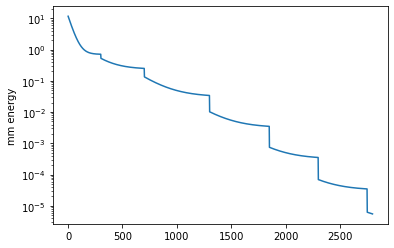

In [4]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

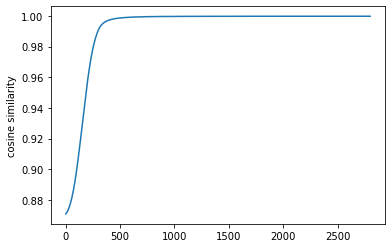

In [5]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# A larger net with 100 -> 10

In [6]:
# define parameters of net
layers = [100, 10]
steps = 5000
bw_lr = 1e-4
alpha = 1e+3
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 3.1812390032880584
mm energy after 100 steps: 2.39587859758383
mm energy after 150 steps: 2.395857737312823
plateau detected, reducing alpha to 100.0
mm energy after 200 steps: 0.2736621440834573
mm energy after 250 steps: 0.27366214407059936
plateau detected, reducing alpha to 10.0
mm energy after 300 steps: 0.027761060971318256
plateau detected, reducing alpha to 1.0
mm energy after 350 steps: 0.0027801173197131183
plateau detected, reducing alpha to 0.1
mm energy after 400 steps: 0.00027805190796073586
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 450 steps: 2.780559261983373e-05
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 500 steps: 2.7805632802848507e-06
reached precision of 10^-5


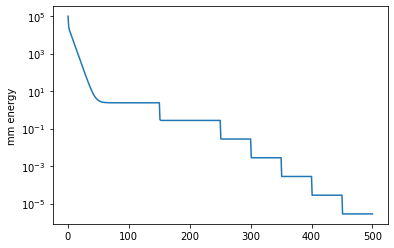

In [7]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

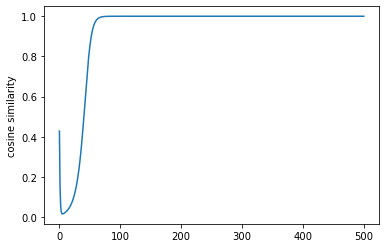

In [8]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# The inverse: 10 -> 100

In [9]:
# define parameters of net
layers = [10, 100]
steps = 5000
bw_lr = 1e-3
alpha = 1e+2
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.3014044291052979
mm energy after 100 steps: 0.20857535235950814
mm energy after 150 steps: 0.2085728866893723
plateau detected, reducing alpha to 10.0
mm energy after 200 steps: 0.022599157985059348
plateau detected, reducing alpha to 1.0
mm energy after 250 steps: 0.002278948137281816
plateau detected, reducing alpha to 0.1
mm energy after 300 steps: 0.0002280869017337342
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 350 steps: 2.2810612834557837e-05
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 400 steps: 2.281080511850424e-06
reached precision of 10^-5


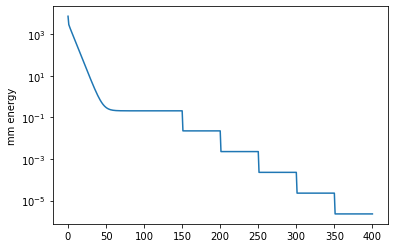

In [10]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

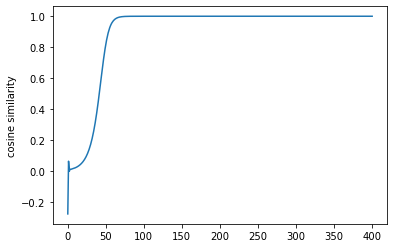

In [12]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# A realistic net with 784 -> 500

In [13]:
# define parameters of net
layers = [784, 500]
steps = 5000
bw_lr = 1e-8
alpha = 1e+7
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy_reg(r, W, B, alpha))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-5:
            print("reached precision of 10^-5")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 3512309.256267527
mm energy after 100 steps: 137.98889432842455
mm energy after 150 steps: 44.700712362522964
mm energy after 200 steps: 44.698234497910256
plateau detected, reducing alpha to 1000000.0
mm energy after 250 steps: 6.48937040613759
mm energy after 300 steps: 6.489370401931849
plateau detected, reducing alpha to 100000.0
mm energy after 350 steps: 0.6796446113508516
mm energy after 400 steps: 0.6796446111624748
plateau detected, reducing alpha to 10000.0
mm energy after 450 steps: 0.06828759666037006
plateau detected, reducing alpha to 1000.0
mm energy after 500 steps: 0.006832007929044286
plateau detected, reducing alpha to 100.0
mm energy after 550 steps: 0.0006832332925315191
plateau detected, reducing alpha to 10.0
mm energy after 600 steps: 6.83236542664288e-05
plateau detected, reducing alpha to 1.0
mm energy after 650 steps: 6.832368676792652e-06
reached precision of 10^-5


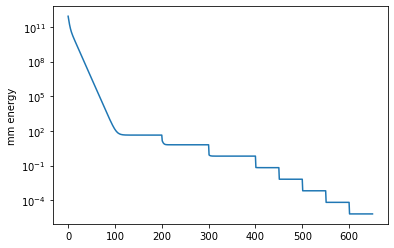

In [14]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

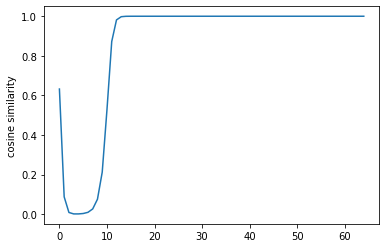

In [15]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[1::10]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()